In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.10.0


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.3.1+cpu


## Loading the Data

In [5]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [6]:
#1. tokenization by each word
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [7]:
#2. numeralization
flatten = lambda l: [item for sublist in l for item in sublist] #function to concat lists
vocabs = list(set(flatten(corpus))) #find and store unique words

In [8]:
vocabs

['banana', 'fruit', 'apple', 'dog', 'cat', 'animal']

In [9]:
word2index = {val:index for index, val in enumerate(vocabs)} #create dict with words and their indexes

In [10]:
word2index

{'banana': 0, 'fruit': 1, 'apple': 2, 'dog': 3, 'cat': 4, 'animal': 5}

In [11]:
#The "<UNK>" token stands for "unknown" and is used to handle words that are not in our vocabulary
vocabs.append('<UNK>')
word2index['<UNK>'] = 6

In [12]:
#creating reverse dictionary to map indices back to words
index2word = {word:index for index, word in word2index.items()}
index2word[5]

'animal'

## Preparing data for training

In [13]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

   
    for doc in corpus:
        
        for i in range(1, len(doc)-1):
            
            center = word2index[doc[i]]
            
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
           
            for each_out in outside:
                skipgrams.append([center, each_out])
                
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)

In [14]:
x, y = random_batch(2, corpus)

In [15]:
x

array([[0],
       [1]])

In [16]:
y

array([[2],
       [0]])

## Model

In [17]:
len(vocabs)

7

In [18]:
embedding = nn.Embedding(7, 2)

In [19]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape

torch.Size([2, 1, 2])

In [20]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss

In [21]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [22]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [23]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [24]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [25]:
loss

tensor(4.8295, grad_fn=<NegBackward0>)

## Model Training

In [26]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.5f}")

Epoch   1000 | Loss: 2.00200
Epoch   2000 | Loss: 1.34385
Epoch   3000 | Loss: 1.16141
Epoch   4000 | Loss: 1.22135
Epoch   5000 | Loss: 1.10690
Epoch   6000 | Loss: 1.17890
Epoch   7000 | Loss: 1.09512
Epoch   8000 | Loss: 1.10108
Epoch   9000 | Loss: 1.09396
Epoch  10000 | Loss: 1.11686


## Plotting the Embeddings

In [28]:
vocabs


['banana', 'fruit', 'apple', 'dog', 'cat', 'animal', '<UNK>']

In [29]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([0])

In [30]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[-0.2286, -0.3253]], grad_fn=<DivBackward0>)

In [31]:
banana_embed_o

tensor([[-0.8531,  0.9889]], grad_fn=<EmbeddingBackward0>)

In [32]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

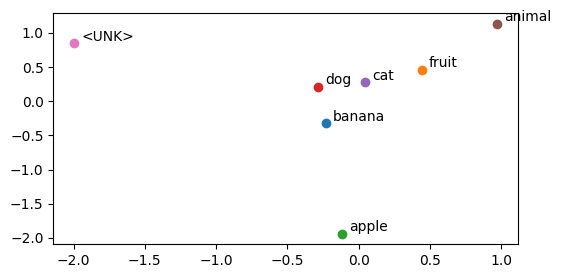

In [33]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [36]:
banana = get_embed('banana')
banana

(-0.22856074571609497, -0.32533782720565796)

In [38]:
fruit = get_embed('fruit')
fruit

(0.4446861147880554, 0.4576405882835388)

In [35]:
unk = get_embed('<UNK>')
unk

(-1.9935381412506104, 0.8467877507209778)

## Implementing Cosine Similarity

In [39]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

0.2091949969770067
-0.9874465055422987
